# Описание 

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
* Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
* Контролировать добросовестность кассиров при продаже алкоголя.

**Задача:**
Построить модель, которая по фотографии определит приблизительный возраст человека. Необходимо получить метрику MAE < 7.

**Описание данных:**
В нашем распоряжении набор фотографий людей с указанием возраста. Порядка 7600 фотографий людей в возрасте от 1 до 100 лет. Медианный возраст 29 лет. 


**Отмечу, что модели обучал на DataSphere, в итоге загружая обученные модели сюда!**


**Все сети обучались на 30 эпохах на Tesla V100**

# Проект

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, MaxPool2D, Conv2D, Dropout, GlobalAveragePooling2D,  BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow import keras


from sklearn.model_selection import train_test_split

import PIL
import cv2

RANDOM_STATE = 12345
LR = 0.0003
EPOCHS = 17
DROP = 0.3
BATCH_SIZE = 32

In [2]:
data = pd.read_csv('./labels.csv')

In [3]:
data

file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]

**Пропишем пути к файлам**

In [4]:
data['file_name'] = data['file_name'].apply(lambda x : r'./final_files/final_files/' + x)

In [5]:
data

file_name  real_age
0     ./final_files/final_files/000000.jpg         4
1     ./final_files/final_files/000001.jpg        18
2     ./final_files/final_files/000002.jpg        80
3     ./final_files/final_files/000003.jpg        50
4     ./final_files/final_files/000004.jpg        17
...                                    ...       ...
7586  ./final_files/final_files/007608.jpg        14
7587  ./final_files/final_files/007609.jpg        37
7588  ./final_files/final_files/007610.jpg        28
7589  ./final_files/final_files/007611.jpg        20
7590  ./final_files/final_files/007612.jpg        47

[7591 rows x 2 columns]

Создадим загрузчки данных

In [6]:
datagen = ImageDataGenerator(rescale=1./255)

In [7]:
data_flow = datagen.flow_from_dataframe(
                    dataframe=data,
                    x_col='file_name',
                    y_col='real_age',
                    batch_size=16,
                    class_mode='raw',
                    seed=42)

Found 7591 validated image filenames.


In [8]:
feature, label = next(data_flow)

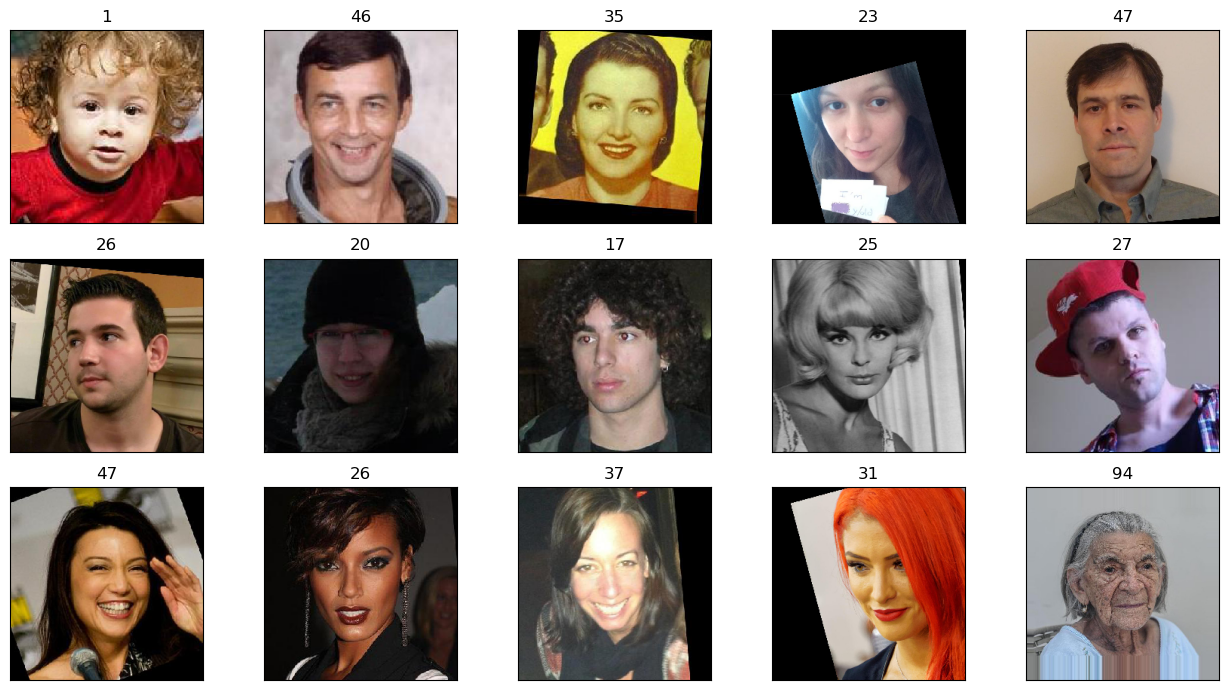

In [9]:
f, a = plt.subplots(nrows=3, ncols=5, figsize=(13, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(feature[i])
    ax.set_title(label[i])
plt.tight_layout() # отсутпы между изображениями

Посмотрим распредeление возрастов

In [10]:
data.real_age.median()

29.0

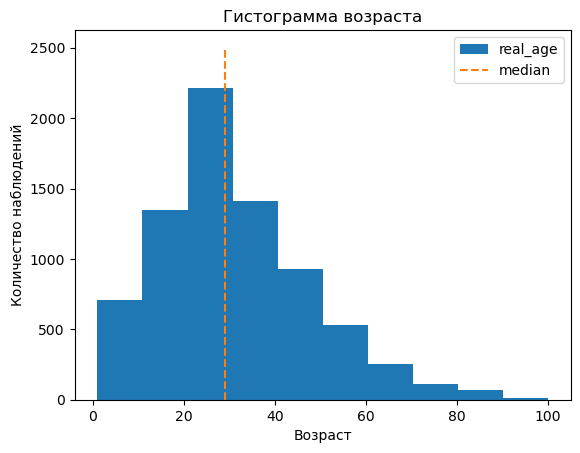

In [11]:
data.real_age.plot(kind='hist')
plt.plot([data.real_age.median()]*300, np.linspace(1, 2500, 300), '--', label='median')
plt.ylabel('Количество наблюдений')
plt.xlabel('Возраст')
plt.title('Гистограмма возраста')
plt.legend();

Таким образом, мы имеем 7600 изображений с лицами

In [12]:
# 256 на 256 размер, 3 канала
# но в дальнейшем, будем обрезать до 224 на 224, так свертки отработают лучше
feature[0].shape

(256, 256, 3)

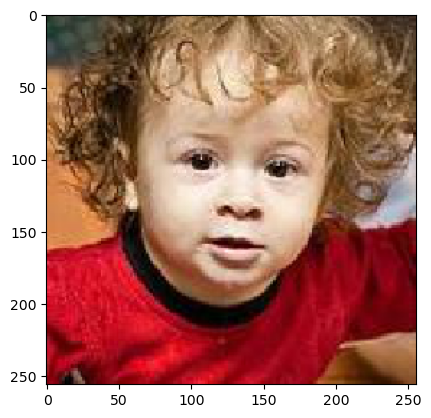

In [13]:
plt.imshow(feature[0])

# Разбиение на выборки

In [14]:
train, test = train_test_split(data, test_size=0.2, shuffle=True,
                             random_state=RANDOM_STATE)

In [15]:
train.shape

(6072, 2)

In [16]:
test.shape

(1519, 2)

In [17]:
train.sample()

file_name  real_age
4889  ./final_files/final_files/004889.jpg        29

# Загрузчики данных + аугментация

Аугментация (англ. augmentation) — увеличение объёма данных через трансформацию существующего датасета.

Внимание! Для обучающей и валидационной выборок нужно создать разные генераторы

In [18]:
# аугментация на train
datagen_train = ImageDataGenerator(
                                   rescale=1./255,
                                   width_shift_range=0.15,
                                   height_shift_range=0.15,
                                   horizontal_flip=True)

datagen_test = ImageDataGenerator(rescale=1./255)

In [19]:
# тренировочный поток

train_datagen_flow = datagen_train.flow_from_dataframe(
                     dataframe=train,
                     x_col='file_name',
                     y_col='real_age',
                     target_size=(224, 224),
                     class_mode='raw',
                     batch_size=BATCH_SIZE,
                     seed=RANDOM_STATE
                     
)

Found 6072 validated image filenames.


In [20]:
# валидационный поток

test_datagen_flow = datagen_test.flow_from_dataframe(
                     dataframe=test,
                     x_col='file_name',
                     y_col='real_age',
                     target_size=(224, 224),
                     class_mode='raw',
                     batch_size=BATCH_SIZE,
                     seed=RANDOM_STATE
                     
)

Found 1519 validated image filenames.


# Архитектура ResNet50 

Для решения проблемы затухающего градиета была создана архитектура ResNet.Главная особенность ResNet заключается в использовании Shortcut Connections — дополнительные связи внутри сети, которые позволяют избежать проблемы затухающего градиента. 

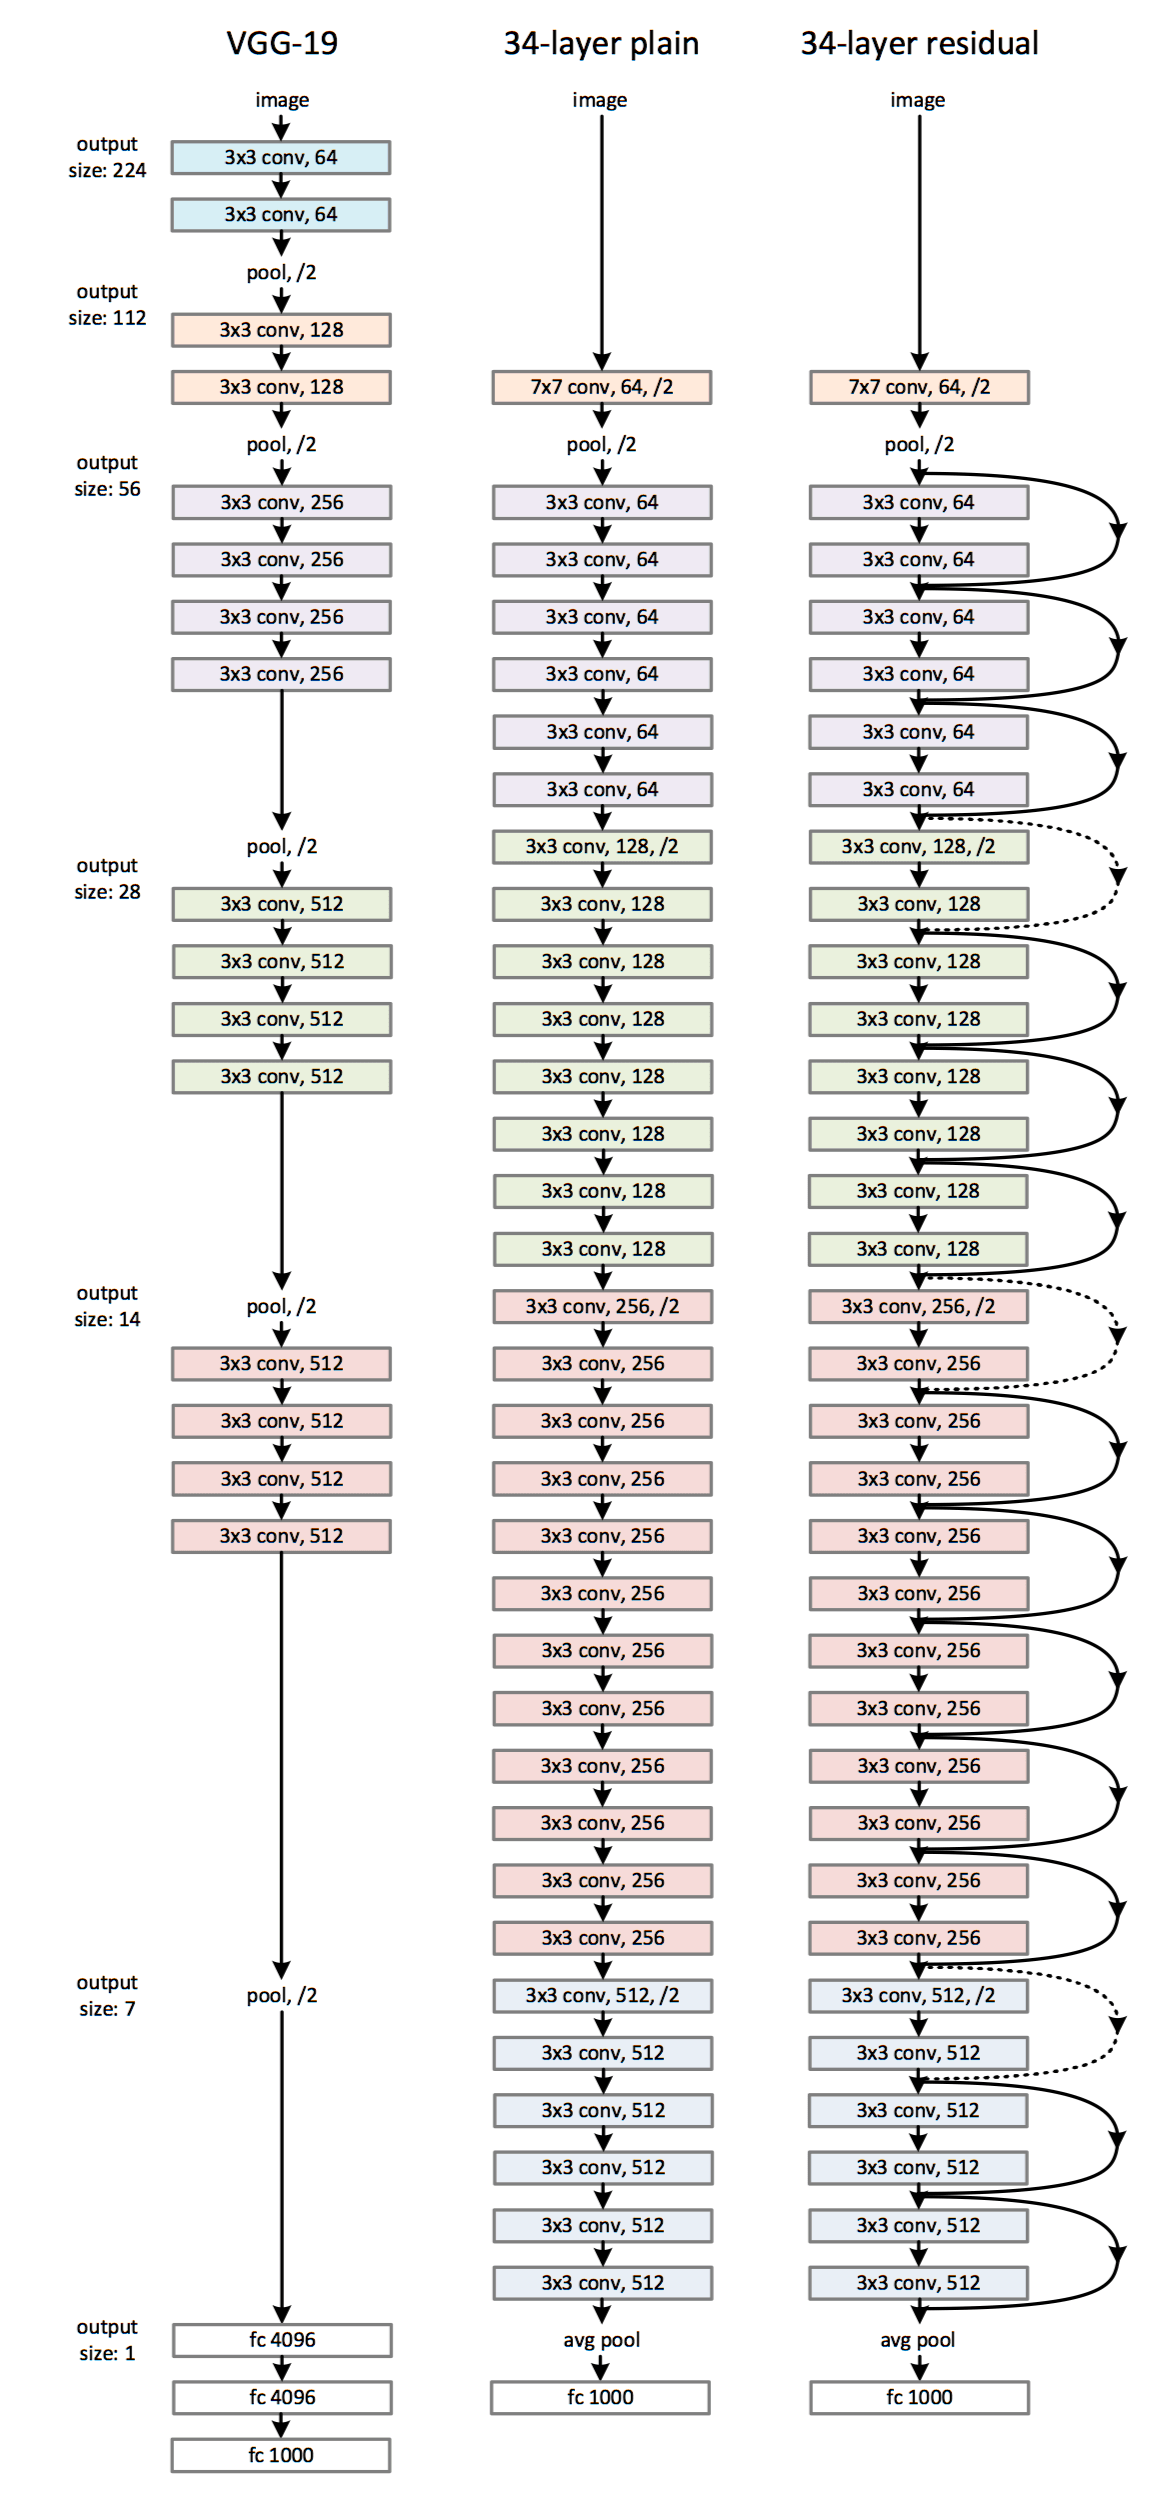

**Как ее правильно читать:**

* “3x3 conv, 256” — свёрточный слой с ядром 3х3 и 256 каналов на выходе.
* “pool, /2” и просто “/2” — уменьшение пространственной размерности вдвое с помощью MaxPooling.
* В колонке “Output” слева указаны пространственные размерности. Они уменьшаются с 224 (это размер входного изображения) и падают до 7х7.
* “fc 4096” — полносвязный (fully-connected) слой с 4096 нейронами.
* “fc 1000” — последний слой с 1000 нейронов. Такое значение обусловлено задачей — классификацией датасета ImageNet, в его сокращённой версии 1000 классов.
* “avg pool” — глобальный пулинг. На вход ему приходит тензор 7х7х512, который называют картой признаков (англ. feature map). Она возникает на выходе свёрточного слоя перед классификационной частью. На выходе слоя глобального пулинга одномерный тензор, размерность которого равна числу каналов — 512. Он состоит из средних значений 512 матриц размером 7x7. Так, из карты признаков размером 3х3х128 на выходе получился бы одномерный тензор размером 128.


Первая часть ResNet - **сверточный слой 7x7 - называется stemming (основа, начало сети)**

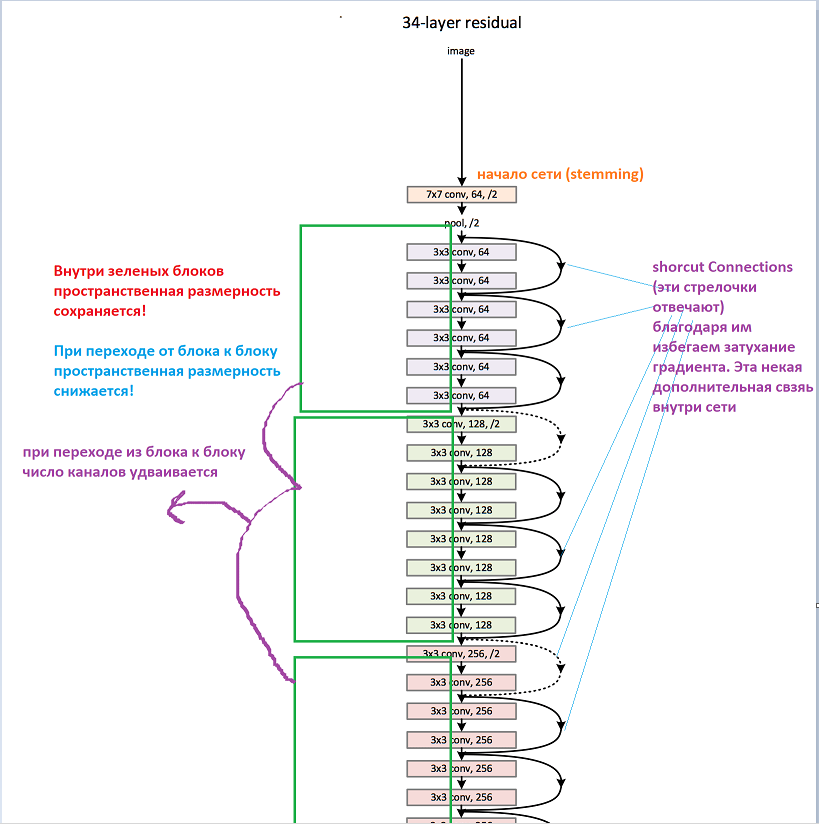

 а **последняя, начиная с "avg pool" - ending(конец чети)**. Это необходимые части архитектуры.
 
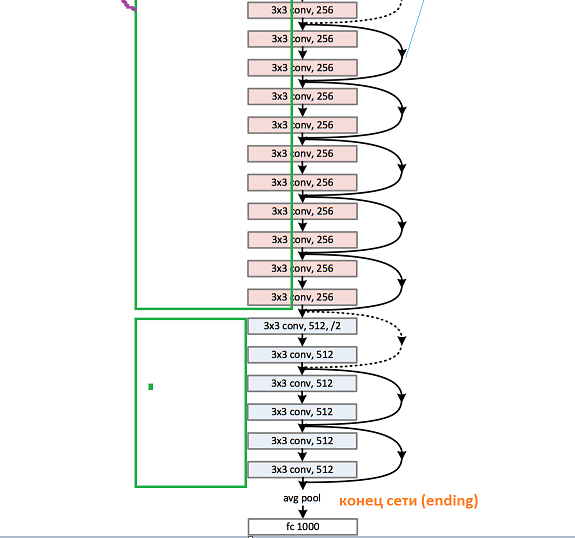

Несмотря на то, что 34-layer residual — это многослойная сеть, она всё ещё работает по принципу «**свёртка увеличивает число каналов, а MaxPool уменьшает размерность»**. 

**Однако теперь он применяется к блокам, а не к отдельным слоям.!!**


Понимая смысл работы сети, **воспользуемся предобученной NN ResNet50**

* **include_top=True** - добавить верхушку, указание на то, что **в конце архитектуры ResNet есть два слоя**: GlobalAveragePooling2D и Dense. Если задать False, то этих слоев не будет

In [21]:
backbone = ResNet50(input_shape=(224, 224, 3),
                include_top=False,
                weights='imagenet')

**не замораживаем веса сети**

In [22]:
# говорим, чтобы костяк  тренировался

backbone.trainable = True

где **backbone (англ. «костяк») — то, что осталось от ResNet50.** То есть то, что осталось после того, как мы убрали концовку сети


In [23]:
# функция для динамического изменения скорости обучения

def scheduler(epoch, lr=LR):
    if epoch < 6:
        return lr
    else:
        return lr * np.exp(-0.1)

Чтобы сеть обучалась, **добавленный сверху backbone полносвязный слой замораживать не стали**. Если бы заморозили вообще все, то сеть не обучалась бы.

Заморозка позволяет избавиться от переобучения и повысить скорость обучения сети:  **градиентному спуску считать производные для замороженных слоёв не нужно.**


## Полный этап Обучение модели

<!--  


backbone = ResNet50(input_shape=(224, 224, 3),
                include_top=False,
                weights='imagenet')




backbone.trainable = True

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dropout(DROP))
model.add(BatchNormalization())
model.add(Dense(800, activation='relu'))
model.add(Dropout(DROP))
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROP))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))
optim = Adam(learning_rate=LR)
model.compile(optimizer=optim, 
              loss='mse',
              metrics=['mae']
         )



callback = LearningRateScheduler(scheduler)

model.fit(train_datagen_flow,
          validation_data=test_datagen_flow,
          steps_per_epoch=len(train_datagen_flow),
          validation_steps=len(test_datagen_flow),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=2,
          shuffle=True,
          callbacks=[callback]
         )

-->

```python

# динамическое изменение learning rate
def scheduler(epoch, lr=LR):
    if epoch < 6:
        return lr
    else:
        return lr * np.exp(-0.1)
    
    

backbone = ResNet50(input_shape=(224, 224, 3),
                include_top=False,
                weights='imagenet')




backbone.trainable = True

model = Sequential()
model.add(backbone)
model.add(GlobalAveragePooling2D())
model.add(Dropout(DROP))
model.add(BatchNormalization())
model.add(Dense(800, activation='relu'))
model.add(Dropout(DROP))
model.add(Dense(256, activation='relu'))
model.add(Dropout(DROP))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='relu'))
optim = Adam(learning_rate=LR)
model.compile(optimizer=optim, 
              loss='mse',
              metrics=['mae']
         )



callback = LearningRateScheduler(scheduler)

model.fit(train_datagen_flow,
          validation_data=test_datagen_flow,
          steps_per_epoch=len(train_datagen_flow),
          validation_steps=len(test_datagen_flow),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          verbose=2,
          shuffle=True,
          callbacks=[callback]
         )


```

```
Found 6072 validated image filenames.
Found 1519 validated image filenames.
Epoch 1/25
190/190 - 124s - loss: 317.2425 - mae: 13.2561 - val_loss: 371.0866 - val_mae: 14.2652
Epoch 2/25
190/190 - 89s - loss: 155.3387 - mae: 9.5353 - val_loss: 429.2415 - val_mae: 15.4656
Epoch 3/25
190/190 - 87s - loss: 128.3384 - mae: 8.6826 - val_loss: 321.8948 - val_mae: 13.2722
Epoch 4/25
190/190 - 90s - loss: 117.0000 - mae: 8.2179 - val_loss: 204.7547 - val_mae: 10.6366
Epoch 5/25
190/190 - 89s - loss: 113.7072 - mae: 8.1162 - val_loss: 184.2254 - val_mae: 10.1207
Epoch 6/25
190/190 - 87s - loss: 97.8272 - mae: 7.4931 - val_loss: 110.3599 - val_mae: 8.1087
Epoch 7/25
190/190 - 89s - loss: 91.0717 - mae: 7.3140 - val_loss: 94.3507 - val_mae: 7.3751
Epoch 8/25
190/190 - 90s - loss: 83.2303 - mae: 6.9212 - val_loss: 88.8687 - val_mae: 7.0548
Epoch 9/25
190/190 - 90s - loss: 76.9388 - mae: 6.6400 - val_loss: 180.0562 - val_mae: 9.5519
Epoch 10/25
190/190 - 89s - loss: 67.5349 - mae: 6.2725 - val_loss: 107.3776 - val_mae: 7.5737
Epoch 11/25
190/190 - 90s - loss: 63.7325 - mae: 6.1035 - val_loss: 92.5639 - val_mae: 7.4665
Epoch 12/25
190/190 - 89s - loss: 57.1990 - mae: 5.7669 - val_loss: 125.2902 - val_mae: 8.1047
Epoch 13/25
190/190 - 90s - loss: 50.6175 - mae: 5.4559 - val_loss: 86.0528 - val_mae: 6.8823
Epoch 14/25
190/190 - 89s - loss: 45.7656 - mae: 5.2115 - val_loss: 108.3574 - val_mae: 7.4424
Epoch 15/25
190/190 - 90s - loss: 41.3255 - mae: 4.9583 - val_loss: 88.8275 - val_mae: 6.7718
Epoch 16/25
190/190 - 89s - loss: 38.5223 - mae: 4.7598 - val_loss: 85.6793 - val_mae: 6.8140
Epoch 17/25
190/190 - 88s - loss: 34.2672 - mae: 4.5406 - val_loss: 81.9793 - val_mae: 6.4534
Epoch 18/25
190/190 - 86s - loss: 32.4919 - mae: 4.4020 - val_loss: 83.2008 - val_mae: 6.5457
Epoch 19/25
190/190 - 86s - loss: 34.7885 - mae: 4.5415 - val_loss: 101.7808 - val_mae: 7.2497
Epoch 20/25
190/190 - 87s - loss: 29.7881 - mae: 4.1949 - val_loss: 75.9409 - val_mae: 6.4352
Epoch 21/25
190/190 - 87s - loss: 26.6129 - mae: 4.0054 - val_loss: 81.7355 - val_mae: 6.4868
Epoch 22/25
190/190 - 87s - loss: 24.9562 - mae: 3.8828 - val_loss: 76.5205 - val_mae: 6.2778
Epoch 23/25
190/190 - 86s - loss: 23.0949 - mae: 3.7235 - val_loss: 79.1396 - val_mae: 6.3800
Epoch 24/25
190/190 - 87s - loss: 22.3781 - mae: 3.6944 - val_loss: 78.1158 - val_mae: 6.3759
Epoch 25/25
190/190 - 89s - loss: 22.0075 - mae: 3.6196 - val_loss: 82.3385 - val_mae: 6.4494

```

# Функция для проверки моделей

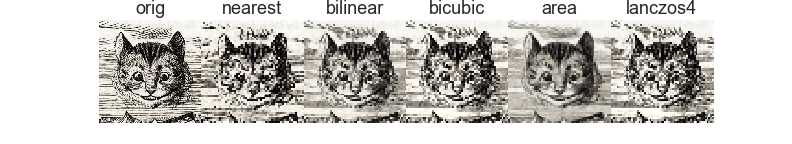


Фактически, **это то, как будут заполняться новые пиксели при модификации размера изображения.** К примеру, интерполяция методом ближайшего соседа (cv2.INTER_NEAREST) просто берёт для каждого пикселя итогового изображения один пиксель исходного, который наиболее близкий к его положению — это самый простой и быстрый способ.

* cv.INTER_NEAREST — интерполяция методом ближайшего соседа (nearest-neighbor interpolation),
* cv.INTER_LINEAR — билинейная интерполяция (bilinear interpolation (используется по умолчанию),
* cv.INTER_CUBIC — бикубическая интерполяция (bicubic interpolation) в окрестности 4×4 пикселей,
* cv.INTER_AREA — передискретизации с использованием отношения площади пикселя,
* cv.INTER_LANCZOS4 — интерполяция Ланцоша (Lanczos interpolation) в окрестности 8×8 пикселей.

In [24]:
def model_resnet50_tran_learn(path, interpolation=cv2.INTER_NEAREST):
    # обрезка разрешения и интерполяция картинки
    # cv.INTER_AREA — передискретизации с использованием отношения площади пикселя,
    # cv.INTER_NEAREST — интерполяция методом ближайшего соседа (nearest-neighbor interpolation),
    img = cv2.resize(cv2.imread(path)[:,:, ::-1], (224, 224), interpolation=interpolation)
    image = np.expand_dims(img, 0) / 255.
    age = model.predict(image)[0][0]
    
    return img, age
    


    

In [25]:
# картинки для проверки

path = [
    './hatt2.png',
    './andreww1.png',
    './pewdiepiee.png',
    './queenn.png']
    
    
real_age = [23, 30, 
           33, 90]

## Тестируем модель 'cv_age_6_44 (Самая точная)

In [26]:
model = keras.models.load_model('cv_age_6_44.h5')

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 800)               1639200   
                                                                 
 batch_normalization_1 (Batc  (None, 800)              3200      
 hNormalization)                                                 
                                                        

1/1 [==============================] - 0s 85ms/step


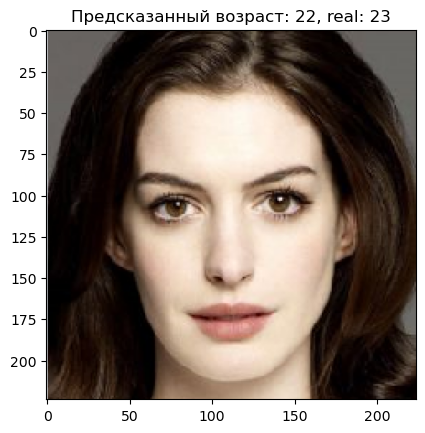

1/1 [==============================] - 0s 94ms/step


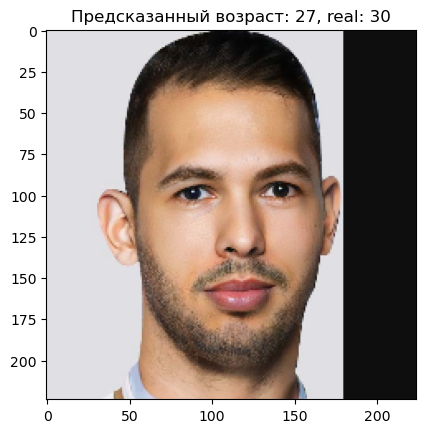

1/1 [==============================] - 0s 94ms/step


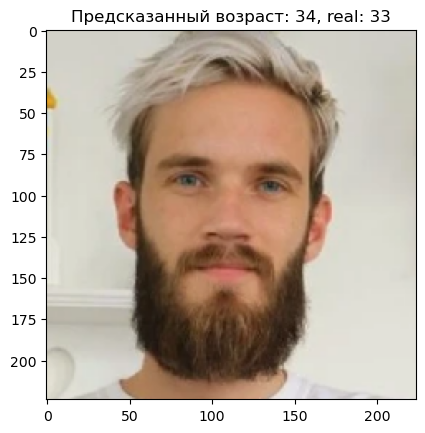

1/1 [==============================] - 0s 94ms/step


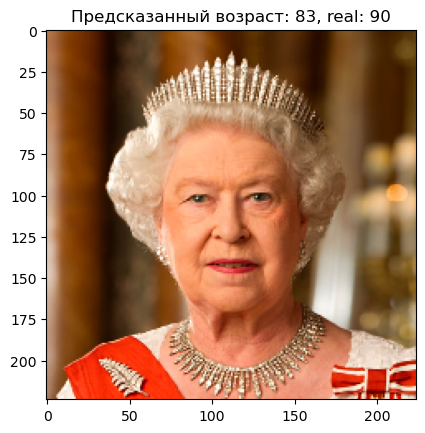

In [28]:


for name, age in zip(path, real_age):
    plt.imshow(model_resnet50_tran_learn(name)[0])
    plt.title(f'Предсказанный возраст: {int(model_resnet50_tran_learn(name)[1])}, real: {age}') # отсутпы между изображениями
    plt.show()

## Тестируем модель 'cv_age_5_94 (more stable)

In [29]:
model = keras.models.load_model('cv_age_5_94.h5')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 700)               1434300   
                                                                 
 dropout_1 (Dropout)         (None, 700)               0         
                                                                 
 dense_4 (Dense)             (None, 200)               140200    
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                      

1/1 [==============================] - 0s 94ms/step


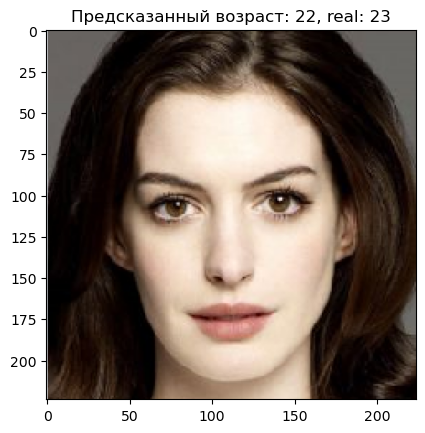

1/1 [==============================] - 0s 94ms/step


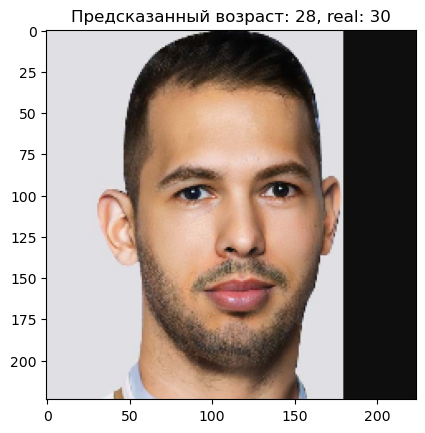

1/1 [==============================] - 0s 85ms/step


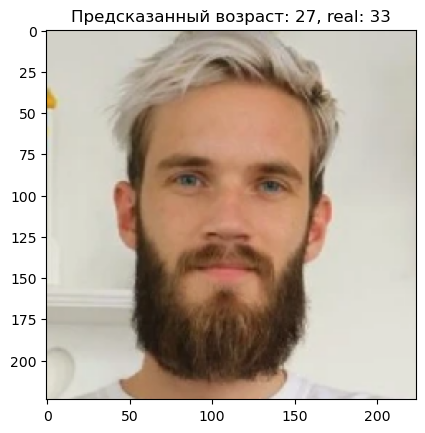

1/1 [==============================] - 0s 114ms/step


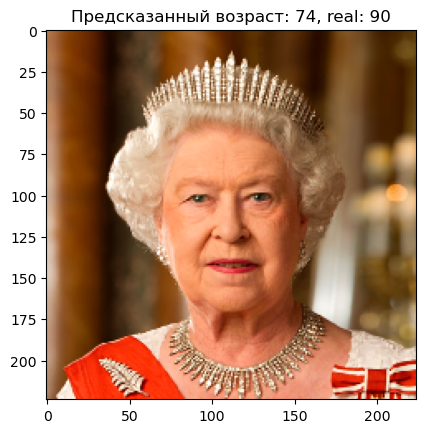

In [31]:


for name, age in zip(path, real_age):
    plt.imshow(model_resnet50_tran_learn(name)[0])
    plt.title(f'Предсказанный возраст: {int(model_resnet50_tran_learn(name)[1])}, real: {age}') # отсутпы между изображениями
    plt.show()

## Тестируем модель 'cv_age_6_36 (only batchnorm)

In [32]:
model = keras.models.load_model('cv_age_6_36.h5')

In [33]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 1000)              2049000   
                                                                 
 dense_1 (Dense)             (None, 700)               700700    
                                                                 
 dense_2 (Dense)             (None, 100)               7

1/1 [==============================] - 0s 121ms/step


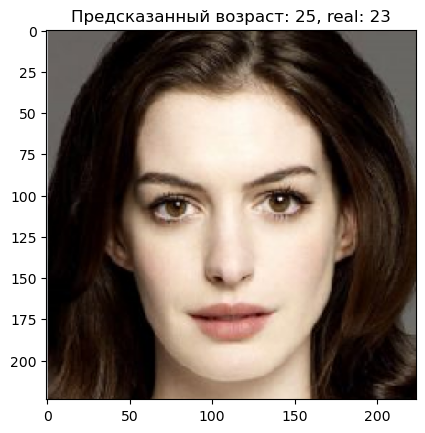

1/1 [==============================] - 0s 107ms/step


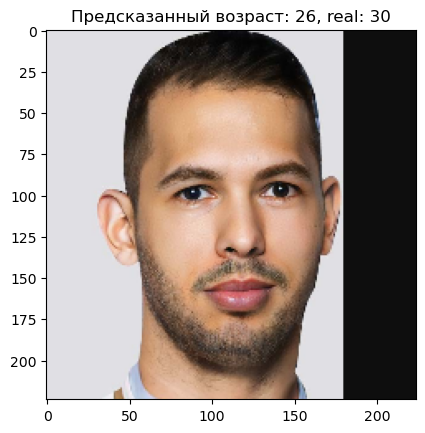

1/1 [==============================] - 0s 94ms/step


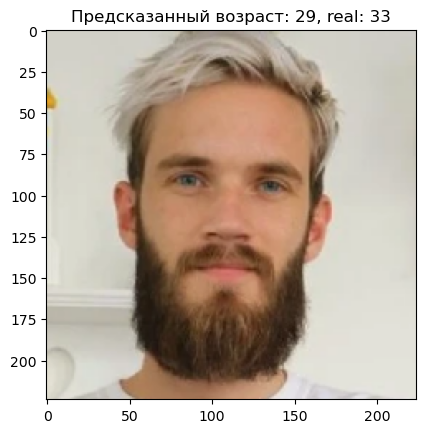

1/1 [==============================] - 0s 107ms/step


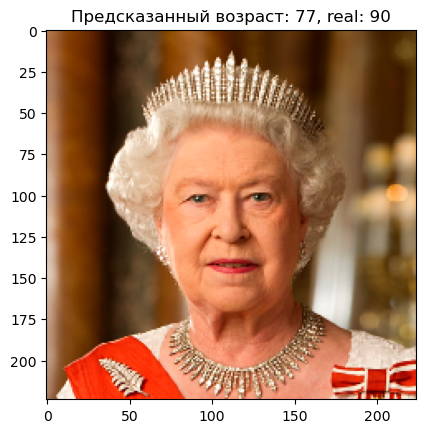

In [34]:


for name, age in zip(path, real_age):
    plt.imshow(model_resnet50_tran_learn(name)[0])
    plt.title(f'Предсказанный возраст: {int(model_resnet50_tran_learn(name)[1])}, real: {age}') # отсутпы между изображениями
    plt.show()

# Выводы

В данном проекте удалось реализовать глубокую нейронную сеть на основе архитектуры ResNet50. **Лучший показатель (самая стабильная и адекватная модель)**, которого удалось достичь - ошибка менее 6.44 на MAE на test. 

**Этого удалось достичь благодаря архитектуре ниже и использовании динамического изменения LearningRate**. Все сети обучались на 30 эпохах на Tesla V100

**Лучшая архитектура:**

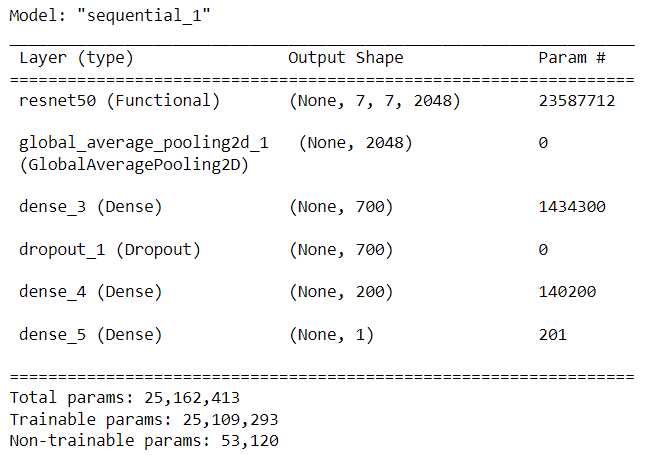